# Classificador de Assuntos

Por Ana Carolina Pereira Rocha

In [4]:
from docutils.nodes import header
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from datetime import timedelta
import time
import sys
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import uuid
import os
from sklearn.calibration import CalibratedClassifierCV
import argparse
import multiprocessing as mp
import numpy as np
import pandas as pd

In [5]:
#!pip --trusted-host=pypi.python.org --trusted-host=pypi.org --trusted-host=files.pythonhosted.org install imbalanced-learn


Verificando o ambiente de execução do conda

In [6]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

envppca


In [7]:
import funcoes as func
from modelo import *

In [8]:
n_cores = mp.cpu_count()
n_cores_grande = round(n_cores * 0.8)
n_cores_pequeno = round(n_cores * 0.35)

#### ATENÇÃO:

A célula abaixo deve ser editada para conter o caminho correto para a pasta onde os dados serão buscados, e a pasta onde serão gravadas as saídas do processamento deste código. O caminho de cada pasta deve ser terminado com a '/' no final.

In [9]:
path_fonte_de_dados = '/home/anarocha/Documents/DocumentosClassificadorAssuntos/'
path_resultados = '/home/anarocha/Documents/DocumentosClassificadorAssuntos/DocsProcessados/'

In [10]:
if not os.path.exists(path_resultados):
    os.makedirs(path_resultados)

In [11]:
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

columnsResultados=['id_execucao', 'data', 'nome','feature_type','tempo_processamento','tamanho_conjunto_treinamento','accuracy','balanced_accuracy','micro_precision','micro_recall','micro_fscore','macro_precision','macro_recall','macro_fscore','best_params_','best_estimator_','grid_scores_','grid_cv_results','confusion_matrix','classification_report','num_estimators','max_samples']
df_resultados = pd.DataFrame(columns = columnsResultados)
nome_arquivo_destino = path_resultados + "Metricas.csv"
if  not (os.path.isfile(nome_arquivo_destino)):
    with open(nome_arquivo_destino, 'a') as f:
        df_resultados.to_csv(f, header=True)
nome_classification_reports = path_resultados + 'ClassificationReport'

id_execucao = str(uuid.uuid1())[:7]
data = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

modelos = []

listaAssuntos=[2546,2086,1855,2594,2458,2704,2656,2140,2435,2029,2583,2554,8808,2117,2021,5280,1904,1844,2055,1907,1806,55220,2506,
                        4437,10570,1783,1888,2478,5356,1773,1663,5272,2215,1767,1661,1690]


Definindo modelos que serão usados

In [12]:
classificadorNB = MultinomialNB()
classificadorRF = RandomForestClassifier(random_state=42)
classificadorSVM = CalibratedClassifierCV(LinearSVC(class_weight='balanced', max_iter=10000,random_state=42),method='sigmoid', cv=5)
classificadorMLP = MLPClassifier(early_stopping= True,random_state=42)

nomeAlgoritmoNB='Multinomial Naive Bayes'
nomeAlgoritmoRF='Random Forest'
nomeAlgoritmoSVM='SVM'
nomeAlgoritmoMLP="Multi-Layer Perceptron"

Pré-processamento dos documentos

In [13]:
path_destino_de_dados = path_fonte_de_dados + 'DocumentosProcessados/'
if not os.path.exists(path_destino_de_dados):
        os.makedirs(path_destino_de_dados)
        
#func.processaDocumentos(path_fonte_de_dados,path_destino_de_dados)
print("Todos os documentos disponíveis foram processados")

Todos os documentos disponíveis foram processados


Recuperando textos

In [14]:
qtdElementosPorAssunto=1000000
df_amostra = func.recupera_amostras_de_todos_regionais(listaAssuntos, qtdElementosPorAssunto, path_destino_de_dados)

Buscando 200 elementos de cada assunto em cada regional
Não foi encontrado o arquivo de documentos do TRT 01. Buscou-se pelo arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/DocumentosProcessados/TRT_01_documentosSelecionadosProcessados.csv
Não foi encontrado o arquivo de documentos do TRT 05. Buscou-se pelo arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/DocumentosProcessados/TRT_05_documentosSelecionadosProcessados.csv
Não foi encontrado o arquivo de documentos do TRT 02. Buscou-se pelo arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/DocumentosProcessados/TRT_02_documentosSelecionadosProcessados.csv
Não foi encontrado o arquivo de documentos do TRT 04. Buscou-se pelo arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/DocumentosProcessados/TRT_04_documentosSelecionadosProcessados.csv
Não foi encontrado o arquivo de documentos do TRT 03. Buscou-se pelo arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/Docume

Juntando os assuntos 55220 e 1855, ambos Indenização por Dano Moral

In [15]:
df_amostra.loc[df_amostra['cd_assunto_nivel_3'] == 55220, 'cd_assunto_nivel_3'] = 1855
df_amostra.loc[df_amostra['cd_assunto_nivel_2'] == 55218, 'cd_assunto_nivel_3'] = 2567

In [16]:
print('Total de textos recuperados: ' + str(len(df_amostra)))
df_amostra = df_amostra.dropna(subset=['texto_stemizado'])
print('Total de textos recuperados com conteúdo: ' + str(len(df_amostra)))

Total de textos recuperados: 1200
Total de textos recuperados com conteúdo: 1197


Analisando tamanho dos textos

Quantidade de textos entre 0 e 400 palavras: 260
Quantidade de textos com mais de 10.000 palavras: 46


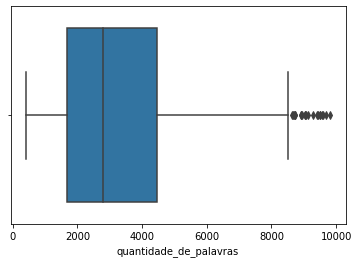

In [17]:
df_amostra['quantidade_de_palavras'] = [len(x.split()) for x in df_amostra['texto_processado'].tolist()]
sns.boxplot(df_amostra['quantidade_de_palavras'])
plt.savefig("{0}{1}.png".format(path_resultados, "Distribuicao_Tamanho_Textos_Original"))

df_amostra_f = df_amostra[((df_amostra.quantidade_de_palavras < 400) & (df_amostra.quantidade_de_palavras > 0))]
print('Quantidade de textos entre 0 e 400 palavras: ' + str(len(df_amostra_f)))
df_amostra_f = df_amostra[(df_amostra.quantidade_de_palavras > 10000)]
print('Quantidade de textos com mais de 10.000 palavras: ' + str(len(df_amostra_f)))
df_amostra.shape
df_amostra_f = df_amostra[((df_amostra.quantidade_de_palavras < 10000) & (df_amostra.quantidade_de_palavras > 400))]
df_amostra_f= df_amostra_f.sort_values(by='quantidade_de_palavras', ascending=True)
df_amostra_f.shape
df_amostra = df_amostra_f
plt.clf()
plt.cla()
plt.close()
sns.boxplot(df_amostra['quantidade_de_palavras'])
plt.savefig("{0}{1}.png".format(path_resultados, "Distribuicao_Tamanho_Textos_Depois_Da_Remocao_De_Textos_Com_Mais_De_400_e_Menos_de_10000"))


In [18]:
print('Total de textos utilizados: ' + str(len(df_amostra)))
X_train, X_test, y_train, y_test = func.splitTrainTest(df_amostra)
print("Amostra de teste de " + str(X_test.shape[0]) + " elementos")
print("Amostra de treinamento de " + str(X_train.shape[0]) + " elementos")


Total de textos utilizados: 891
Amostra de teste de 179 elementos
Amostra de treinamento de 712 elementos


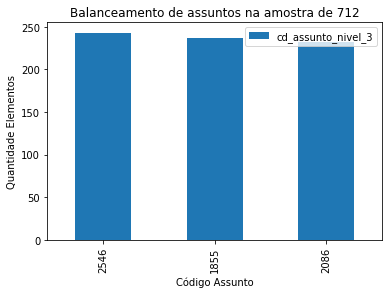

In [19]:
title = "Balanceamento de assuntos na amostra de "  + str(X_train.shape[0])
func.mostra_balanceamento_assunto(y_train.value_counts(), title, "Quantidade Elementos", "Código Assunto", path_resultados, y_train.shape[0])

## Criando matrizes

#### TF-IDF

In [20]:
start_time = time.time()
tfidf_transformer,x_tfidf_train, x_tfidf_test = func.extraiFeaturesTFIDF_train_test(df_amostra, X_train['texto_stemizado'], X_test['texto_stemizado'], path_resultados)
total_time = time.time() - start_time
print("Tempo para montar matrizes TF-IDF (features:  "+ str(x_tfidf_train.shape[1]) + ") :" +   str(timedelta(seconds=total_time)))


Tempo para montar matrizes TF-IDF (features:  6304) :0:00:02.406011


#### BM25

In [21]:
bm25_transformer,x_bm25_train, x_bm25_test = func.extraiFeaturesBM25(df_amostra, tfidf_transformer, x_tfidf_train, x_tfidf_test, path_resultados)

/home/anarocha/Documents/myGit/classificadorDeAssuntos/Codigo/VersaoParaPublicacao/BM25_Transformer.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/anarocha/Documents/myGit/classificadorDeAssuntos/Codigo/VersaoParaPublicacao/BM25_Transformer.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


#### LSI

In [22]:
lsi100_transformer,x_lsi100_train, x_lsi100_test = func.extraiFeaturesLSI(df_amostra, X_train['texto_stemizado'], X_test['texto_stemizado'], 100, path_resultados)
lsi250_transformer,x_lsi250_train, x_lsi250_test = func.extraiFeaturesLSI(df_amostra, X_train['texto_stemizado'], X_test['texto_stemizado'], 250, path_resultados)



## Grid Search
#### Com TF-IDF

Coloque aqui a quantidade de configurações diferentes a serem testadas no GridSearch para cada modelo. 

In [23]:
numero_de_configuracoes_por_modelo=2

#### Multinomial Naïve-Bayes (NB)

In [24]:
param_grid_NB = {
    'estimator__n_estimators': [3,5],
    'estimator__max_samples': [0.8,0.5],
    'estimator__base_estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
}
modeloNB = func.chama_treinamento_modelo(x_tfidf_train, y_train, x_tfidf_test,y_test, classificadorNB, nomeAlgoritmoNB , 'TFIDF',param_grid_NB,numero_de_configuracoes_por_modelo,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloNB.getNome(),modeloNB.getFeatureType(),modeloNB.getMicroPrecision(),modeloNB])

>> Fazendo Grid Search para classificador Multinomial Naive Bayes
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tempo para execução do GridSearch para OVR Balanced Bagging Multinomial Naive Bayes para 712 elementos:  0:00:02.764313
>> Testando classificador TFIDF_Multinomial Naive Bayes
Tempo para fazer a predicao de  179 elementos:  0:00:00.042968
Tempo para recuperar métricas:  0:00:00.007390
 
Nome modelo: TFIDF_Multinomial Naive Bayes
Quantidade de elementos de treinamento: 712
Tempo de treinamento: 0:00:00.114591
Feature Type: TFIDF
Accuracy: 0.5363128491620112
Balanced Accuracy: 0.5387004585139125
macro_precision 0.5281920125909896 
macro_recall    0.5387004585139125 
macro_fscore    0.5292326558868615
micro_precision 0.5274493684172348 
micro_recall    0.5363128491620112 
micro_fscore    0.5276427498199544


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished


#### SVM

In [25]:
param_grid_SVM = {
    'estimator__n_estimators': [3, 5],
    'estimator__max_samples': [0.8, 0.5],
    'estimator__base_estimator__base_estimator__C': [0.01, 0.1, 1, 10]
}
modeloSVM = func.chama_treinamento_modelo(x_tfidf_train,y_train, x_tfidf_test,y_test, classificadorSVM, nomeAlgoritmoSVM,'TFIDF',param_grid_SVM, numero_de_configuracoes_por_modelo,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloSVM.getNome(),modeloSVM.getFeatureType(),modeloSVM.getMicroPrecision(),modeloSVM])

>> Fazendo Grid Search para classificador SVM
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tempo para execução do GridSearch para OVR Balanced Bagging SVM para 712 elementos:  0:00:06.258452
>> Testando classificador TFIDF_SVM
Tempo para fazer a predicao de  179 elementos:  0:00:00.155959
Tempo para recuperar métricas:  0:00:00.011008
 
Nome modelo: TFIDF_SVM
Quantidade de elementos de treinamento: 712
Tempo de treinamento: 0:00:00.746663
Feature Type: TFIDF
Accuracy: 0.5307262569832403
Balanced Accuracy: 0.5323063877897117
macro_precision 0.5283216960129528 
macro_recall    0.5323063877897117 
macro_fscore    0.5292641309747511
micro_precision 0.527678138345324 
micro_recall    0.5307262569832403 
micro_fscore    0.5281530146348951


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.5s finished
/home/anarocha/anaconda3/envs/envppca/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Random Forest (RF)

In [26]:
param_grid_RF = {
    'estimator__n_estimators': [3,5],
    'estimator__max_samples': [0.8,0.5],
    'estimator__base_estimator__max_depth': [30,50,100],
    'estimator__base_estimator__n_estimators': [100,200,300],
    'estimator__base_estimator__min_samples_leaf': [0.05, 0.1, 0.5],
    'estimator__base_estimator__min_samples_split': [0.05, 0.1, 0.5],
    'estimator__base_estimator__max_features': [0.3, 0.5, 0.8]
}
modeloRF = func.chama_treinamento_modelo(x_tfidf_train,y_train, x_tfidf_test,y_test, classificadorRF, nomeAlgoritmoRF,'TFIDF',param_grid_RF, numero_de_configuracoes_por_modelo,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloRF.getNome(),modeloRF.getFeatureType(),modeloRF.getMicroPrecision(),modeloRF])

>> Fazendo Grid Search para classificador Random Forest
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tempo para execução do GridSearch para OVR Balanced Bagging Random Forest para 712 elementos:  0:00:36.034927
>> Testando classificador TFIDF_Random Forest
Tempo para fazer a predicao de  179 elementos:  0:00:01.665103
Tempo para recuperar métricas:  0:00:00.010965
 
Nome modelo: TFIDF_Random Forest
Quantidade de elementos de treinamento: 712
Tempo de treinamento: 0:00:08.830328
Feature Type: TFIDF
Accuracy: 0.5698324022346368
Balanced Accuracy: 0.5716066829972992
macro_precision 0.5736793311893718 
macro_recall    0.5716066829972992 
macro_fscore    0.5671145355243238
micro_precision 0.5736389096324579 
micro_recall    0.5698324022346368 
micro_fscore    0.5662683873227097


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   27.2s finished


#### Multi-layer Perceptron

In [27]:
param_grid_MLP = {
    'estimator__n_estimators': [3,5],
    'estimator__max_samples': [0.8,0.5],
    'estimator__base_estimator__hidden_layer_sizes': [(10,10),(10,5,10)],
    'estimator__base_estimator__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'estimator__base_estimator__solver': ['sgd', 'adam','lbfgs'],
    'estimator__base_estimator__alpha': [0.001, 0.01, 0.05, 0.1],
    'estimator__base_estimator__learning_rate': ['constant','adaptive','invscaling'],
    'estimator__base_estimator__max_iter': [200,300,400]
}
modeloMLP = func.chama_treinamento_modelo(x_tfidf_train,y_train, x_tfidf_test,y_test, classificadorMLP,nomeAlgoritmoMLP, 'TFIDF',param_grid_MLP, numero_de_configuracoes_por_modelo,n_cores_pequeno,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloMLP.getNome(),modeloMLP.getFeatureType(),modeloMLP.getMicroPrecision(),modeloMLP])

>> Fazendo Grid Search para classificador Multi-Layer Perceptron
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] estimator__n_estimators=3, estimator__max_samples=0.8, estimator__base_estimator__solver=lbfgs, estimator__base_estimator__max_iter=300, estimator__base_estimator__learning_rate=invscaling, estimator__base_estimator__hidden_layer_sizes=(10, 10), estimator__base_estimator__alpha=0.001, estimator__base_estimator__activation=relu 
[CV]  estimator__n_estimators=3, estimator__max_samples=0.8, estimator__base_estimator__solver=lbfgs, estimator__base_estimator__max_iter=300, estimator__base_estimator__learning_rate=invscaling, estimator__base_estimator__hidden_layer_sizes=(10, 10), estimator__base_estimator__alpha=0.001, estimator__base_estimator__activation=relu, total=  18.2s
[CV] estimator__n_estimators=3, estimator__max_samples=0.8, estimator__base_estimator__solver=lbfgs, estimator__base_estimator__max_iter=300, estimator__base_estimator__learning_rate=invscal

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s
/home/anarocha/anaconda3/envs/envppca/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anarocha/anaconda3/envs/envppca/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anarocha/anaconda3/envs/envppca/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anarocha/anaconda3/envs/envppca/lib/python3.7/site-pa

#### Criando dicionarios com a melhor configuração de cada modelo

In [28]:
#MNB
param_grid_melhor_NB = {
    'estimator__n_estimators': [modeloNB.getBestParams().get('estimator__n_estimators')],
    'estimator__max_samples': [modeloNB.getBestParams().get('estimator__max_samples')],
    'estimator__base_estimator__alpha': [modeloNB.getBestParams().get('estimator__base_estimator__alpha')]
}

# SVM
param_grid_melhor_SVM = {
    'estimator__n_estimators': [modeloSVM.getBestParams().get('estimator__n_estimators')],
    'estimator__max_samples': [modeloSVM.getBestParams().get('estimator__max_samples')],
    'estimator__base_estimator__base_estimator__C': [modeloSVM.getBestParams().get('estimator__base_estimator__base_estimator__C')]
}

# RF
param_grid_melhor_RF = {
    'estimator__n_estimators': [modeloRF.getBestParams().get('estimator__n_estimators')],
    'estimator__max_samples': [modeloRF.getBestParams().get('estimator__max_samples')],
    'estimator__base_estimator__max_depth': [modeloRF.getBestParams().get('estimator__base_estimator__max_depth')],
    'estimator__base_estimator__n_estimators': [modeloRF.getBestParams().get('estimator__base_estimator__n_estimators')],
    'estimator__base_estimator__min_samples_leaf': [modeloRF.getBestParams().get('estimator__base_estimator__min_samples_leaf')],
    'estimator__base_estimator__min_samples_split': [modeloRF.getBestParams().get('estimator__base_estimator__min_samples_split')],
    'estimator__base_estimator__max_features': [modeloRF.getBestParams().get('estimator__base_estimator__max_features')]
}

# MLP
param_grid_melhor_MLP = {
    'estimator__n_estimators': [modeloMLP.getBestParams().get('estimator__n_estimators')],
    'estimator__max_samples': [modeloMLP.getBestParams().get('estimator__max_samples')],
    'estimator__base_estimator__hidden_layer_sizes': [modeloMLP.getBestParams().get('estimator__base_estimator__hidden_layer_sizes')],
    'estimator__base_estimator__activation': [modeloMLP.getBestParams().get('estimator__base_estimator__activation')],
    'estimator__base_estimator__solver': [modeloMLP.getBestParams().get('estimator__base_estimator__solver')],
    'estimator__base_estimator__alpha': [modeloMLP.getBestParams().get('estimator__base_estimator__alpha')],
    'estimator__base_estimator__learning_rate': [modeloMLP.getBestParams().get('estimator__base_estimator__learning_rate')],
    'estimator__base_estimator__max_iter': [modeloMLP.getBestParams().get('estimator__base_estimator__max_iter')]
}


#### BM25

In [29]:
modeloNB_BM25 = func.chama_treinamento_modelo(x_bm25_train,y_train, x_bm25_test,y_test, classificadorNB, nomeAlgoritmoNB,'BM25',param_grid_melhor_NB, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloNB_BM25.getNome(),modeloNB_BM25.getFeatureType(),modeloNB_BM25.getMicroPrecision(),modeloNB_BM25])

modeloSVM_BM25 = func.chama_treinamento_modelo(x_bm25_train,y_train, x_bm25_test,y_test, classificadorSVM, nomeAlgoritmoSVM,'BM25',param_grid_melhor_SVM, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloSVM_BM25.getNome(),modeloSVM_BM25.getFeatureType(),modeloSVM_BM25.getMicroPrecision(),modeloSVM_BM25])

modeloRF_BM25 = func.chama_treinamento_modelo(x_bm25_train,y_train, x_bm25_test,y_test, classificadorRF, nomeAlgoritmoRF,'BM25',param_grid_melhor_RF, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloRF_BM25.getNome(),modeloRF_BM25.getFeatureType(),modeloRF_BM25.getMicroPrecision(),modeloRF_BM25])

modeloMLP_BM25 = func.chama_treinamento_modelo(x_bm25_train,y_train, x_bm25_test,y_test, classificadorMLP, nomeAlgoritmoMLP,'BM25',param_grid_melhor_MLP, 1,n_cores_pequeno,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloMLP_BM25.getNome(),modeloMLP_BM25.getFeatureType(),modeloMLP_BM25.getMicroPrecision(),modeloMLP_BM25])



>> Fazendo Grid Search para classificador Multinomial Naive Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo para execução do GridSearch para OVR Balanced Bagging Multinomial Naive Bayes para 712 elementos:  0:00:00.413208
>> Testando classificador BM25_Multinomial Naive Bayes
Tempo para fazer a predicao de  179 elementos:  0:00:00.072386
Tempo para recuperar métricas:  0:00:00.017164
 
Nome modelo: BM25_Multinomial Naive Bayes
Quantidade de elementos de treinamento: 712
Tempo de treinamento: 0:00:00.114066
Feature Type: BM25
Accuracy: 0.5363128491620112
Balanced Accuracy: 0.5383078952327115
macro_precision 0.5283235581622678 
macro_recall    0.5383078952327115 
macro_fscore    0.5242365477423655
micro_precision 0.5276212749225905 
micro_recall    0.5363128491620112 
micro_fscore    0.5227494388308463
>> Fazendo Grid Search para classificador SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo para execução do GridSearch para OVR Balanced Bagging 

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.3s finished
/home/anarocha/anaconda3/envs/envppca/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   10.7s remaining:    7.2s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   20.2s finished


#### LSI 100

In [30]:
modeloSVM_LSI100 = func.chama_treinamento_modelo(x_lsi100_train,y_train, x_lsi100_test ,y_test, classificadorSVM,nomeAlgoritmoSVM, 'LSI100',param_grid_melhor_SVM, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloSVM_LSI100.getNome(),modeloSVM_LSI100.getFeatureType(),modeloSVM_LSI100.getMicroPrecision(),modeloSVM_LSI100])

modeloRF_LSI100 = func.chama_treinamento_modelo(x_lsi100_train, y_train,x_lsi100_test ,y_test, classificadorRF,nomeAlgoritmoRF, 'LSI100',param_grid_melhor_RF, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloRF_LSI100.getNome(),modeloRF_LSI100.getFeatureType(),modeloRF_LSI100.getMicroPrecision(),modeloRF_LSI100])

modeloMLP_LSI100 = func.chama_treinamento_modelo(x_lsi100_train,y_train, x_lsi100_test ,y_test, classificadorMLP, nomeAlgoritmoMLP,'LSI100',param_grid_melhor_MLP, 1,n_cores_pequeno,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloMLP_LSI100.getNome(),modeloMLP_LSI100.getFeatureType(),modeloMLP_LSI100.getMicroPrecision(),modeloMLP_LSI100])


>> Fazendo Grid Search para classificador SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo para execução do GridSearch para OVR Balanced Bagging SVM para 712 elementos:  0:00:01.534390
>> Testando classificador LSI100_SVM
Tempo para fazer a predicao de  179 elementos:  0:00:00.091161
Tempo para recuperar métricas:  0:00:00.038974
 
Nome modelo: LSI100_SVM
Quantidade de elementos de treinamento: 712
Tempo de treinamento: 0:00:00.409626
Feature Type: LSI100
Accuracy: 0.553072625698324
Balanced Accuracy: 0.5545286100119339
macro_precision 0.5503517144883369 
macro_recall    0.5545286100119339 
macro_fscore    0.5505291005291005
micro_precision 0.5497867162396012 
micro_recall    0.553072625698324 
micro_fscore    0.5494945464219207
>> Fazendo Grid Search para classificador Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo para execução do GridSearch para OVR Balanced Bagging Random Forest para 712 elementos:  0:00:10.602722
>> Testando clas

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    4.1s remaining:    2.7s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.3s finished


#### LSI 250

In [31]:
modeloSVM_LSI250 = func.chama_treinamento_modelo(x_lsi250_train,y_train, x_lsi250_test ,y_test, classificadorSVM,nomeAlgoritmoSVM, 'LSI250',param_grid_melhor_SVM, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloSVM_LSI250.getNome(),modeloSVM_LSI250.getFeatureType(),modeloSVM_LSI250.getMicroPrecision(),modeloSVM_LSI250])

modeloRF_LSI250 = func.chama_treinamento_modelo(x_lsi250_train, y_train,x_lsi250_test ,y_test, classificadorRF,nomeAlgoritmoRF, 'LSI250',param_grid_melhor_RF, 1,n_cores_grande,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloRF_LSI250.getNome(),modeloRF_LSI250.getFeatureType(),modeloRF_LSI250.getMicroPrecision(),modeloRF_LSI250])

modeloMLP_LSI250 = func.chama_treinamento_modelo(x_lsi250_train,y_train, x_lsi250_test ,y_test, classificadorMLP, nomeAlgoritmoMLP,'LSI250',param_grid_melhor_MLP, 1,n_cores_pequeno,id_execucao ,data,path_resultados,df_resultados,nome_arquivo_destino,X_test)
modelos.append([modeloMLP_LSI250.getNome(),modeloMLP_LSI250.getFeatureType(),modeloMLP_LSI250.getMicroPrecision(),modeloMLP_LSI250])


>> Fazendo Grid Search para classificador SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo para execução do GridSearch para OVR Balanced Bagging SVM para 712 elementos:  0:00:01.785307
>> Testando classificador LSI250_SVM
Tempo para fazer a predicao de  179 elementos:  0:00:00.038621
Tempo para recuperar métricas:  0:00:00.006254
 
Nome modelo: LSI250_SVM
Quantidade de elementos de treinamento: 712
Tempo de treinamento: 0:00:00.446137
Feature Type: LSI250
Accuracy: 0.547486033519553
Balanced Accuracy: 0.5488819797751398
macro_precision 0.5454833637654697 
macro_recall    0.5488819797751398 
macro_fscore    0.5458728789186081
micro_precision 0.5450918404471994 
micro_recall    0.547486033519553 
micro_fscore    0.5449747181397949
>> Fazendo Grid Search para classificador Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo para execução do GridSearch para OVR Balanced Bagging Random Forest para 712 elementos:  0:00:14.244062
>> Testando clas

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    5.0s remaining:    3.4s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.4s finished


Encontrando o modelo vencedor

In [32]:
modelos_df = pd.DataFrame(modelos, columns=['Nome Modelo','Feature Type','micro_precision','Modelo'])
modelos_df= modelos_df.sort_values(by='micro_precision', ascending=False)
print("O modelo vencedor foi o " + modelos_df.iloc[0]['Nome Modelo'] + ", com " + (str("%.2f" % modelos_df.iloc[0]['micro_precision'])) + " de micro precisão")

modelo_vencedor = modelos_df.iloc[0]['Modelo']

arquivoPickle = open(path_resultados + "MelhorModelo.p", 'wb')
pickle.dump(modelo_vencedor.getBestEstimator(), arquivoPickle)
arquivoPickle.close()

if modelo_vencedor.getFeatureType() == 'LSI100':
    feature_vencedora = open(path_resultados + "MelhorModeloFeature.p", 'wb')
    pickle.dump(lsi100_transformer, feature_vencedora)
    feature_vencedora.close()
elif modelo_vencedor.getFeatureType() == 'LSI250':
    feature_vencedora = open(path_resultados + "MelhorModeloFeature.p", 'wb')
    pickle.dump(lsi250_transformer, feature_vencedora)
    feature_vencedora.close()
elif modelo_vencedor.getFeatureType() == 'TFIDF':
    feature_vencedora = open(path_resultados + "MelhorModeloFeature.p", 'wb')
    pickle.dump(tfidf_transformer, feature_vencedora)
    feature_vencedora.close()
elif modelo_vencedor.getFeatureType() == 'BM25':
    feature_vencedora = open(path_resultados + "MelhorModeloFeature.p", 'wb')
    pickle.dump(bm25_transformer, feature_vencedora)
    feature_vencedora.close()
    
print("O modelo para transformação dos textos pré-processados se encontra no arquivo " + path_resultados + "MelhorModeloFeature.p" + " e o modelo de classificação no arquivo " + path_resultados + "MelhorModelo.p")


O modelo vencedor foi o TFIDF_Multi-Layer Perceptron, com 0.58 de micro precisão
O modelo para transformação dos textos pré-processados se encontra no arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/DocsProcessados/MelhorModeloFeature.p e o modelo de classificação no arquivo /home/anarocha/Documents/DocumentosClassificadorAssuntos/DocsProcessados/MelhorModelo.p
